<a href="https://colab.research.google.com/github/eghib22/Store-Sales-Forecasting/blob/main/model_experiment_dlinear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

! mkdir ~/.kaggle
from google.colab import files
files.upload()
!mv "kaggle.json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!ls -l ~/.kaggle/

!kaggle competitions download -c walmart-recruiting-store-sales-forecasting
! unzip walmart-recruiting-store-sales-forecasting
!unzip '*.csv.zip'
!unzip '*.csv.zip'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/root/.kaggle’: File exists


Saving kaggle.json to kaggle.json
total 4
-rw------- 1 root root 71 Jul  6 15:21 kaggle.json
walmart-recruiting-store-sales-forecasting.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  walmart-recruiting-store-sales-forecasting.zip
replace features.csv.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: features.csv.zip        
replace sampleSubmission.csv.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sampleSubmission.csv.zip  
replace stores.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: stores.csv              
replace test.csv.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv.zip            
replace train.csv.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv.zip           
Archive:  test.csv.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                

Archive:  features.csv.zip
replace features.csv? [y]es, [n]o, [A]ll, [N]one, [r]ena

In [2]:

!pip install wandb
import wandb
wandb.login()
wandb.init(project="Store-Sales-Forecasting", entity="agasi22-free-university-of-tbilisi-", name="Dlinear-training-run")


wandb: Currently logged in as: agasi22 (agasi22-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

In [4]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
stores_df = pd.read_csv('stores.csv')
features_df = pd.read_csv('features.csv')

print("Dataset shapes:")
print(f"Train: {train_df.shape}")
print(f"Test: {test_df.shape}")
print(f"Stores: {stores_df.shape}")
print(f"Features: {features_df.shape}")

print("\nTrain data info:")
print(train_df.info())
print("\nTrain data head:")
print(train_df.head())

Dataset shapes:
Train: (421570, 5)
Test: (115064, 4)
Stores: (45, 3)
Features: (8190, 12)

Train data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB
None

Train data head:
   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False


In [5]:
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])
features_df['Date'] = pd.to_datetime(features_df['Date'])

# Merge datasets
train_merged = train_df.merge(stores_df, on='Store', how='left')
train_merged = train_merged.merge(features_df, on=['Store', 'Date'], how='left')

test_merged = test_df.merge(stores_df, on='Store', how='left')
test_merged = test_merged.merge(features_df, on=['Store', 'Date'], how='left')

print("Merged data shapes:")
print(f"Train merged: {train_merged.shape}")
print(f"Test merged: {test_merged.shape}")

Merged data shapes:
Train merged: (421570, 17)
Test merged: (115064, 16)


In [7]:
def create_features(df):
    """Create time-based and other features"""
    df = df.copy()

    # Time-based features
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['Week'] = df['Date'].dt.isocalendar().week
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['Quarter'] = df['Date'].dt.quarter
    df['IsMonthStart'] = df['Date'].dt.is_month_start.astype(int)
    df['IsMonthEnd'] = df['Date'].dt.is_month_end.astype(int)

    # Holiday features - check if column exists first
    if 'IsHoliday' in df.columns:
        df['IsHoliday'] = df['IsHoliday'].astype(int)
    else:
        print("Warning: 'IsHoliday' column not found. Creating default values.")
        df['IsHoliday'] = 0  # Default to no holiday

    # Fill missing values for numeric columns
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    for col in numeric_columns:
        if df[col].isnull().sum() > 0:
            median_val = df[col].median()
            df[col] = df[col].fillna(median_val)
            print(f"Filled {df[col].isnull().sum()} missing values in {col} with median: {median_val}")

    # Handle categorical variables
    categorical_columns = ['Type']
    for col in categorical_columns:
        if col in df.columns:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            print(f"Encoded categorical column: {col}")
        else:
            print(f"Warning: Categorical column '{col}' not found in dataframe")

    return df

# Apply feature engineering
train_processed = create_features(train_merged)
test_processed = create_features(test_merged)

print("Feature engineering completed")
print(f"Train processed shape: {train_processed.shape}")
print(f"Test processed shape: {test_processed.shape}")


Filled 0 missing values in MarkDown1 with median: 5347.45
Filled 0 missing values in MarkDown2 with median: 192.0
Filled 0 missing values in MarkDown3 with median: 24.6
Filled 0 missing values in MarkDown4 with median: 1481.31
Filled 0 missing values in MarkDown5 with median: 3359.45
Encoded categorical column: Type
Filled 0 missing values in MarkDown1 with median: 4842.29
Filled 0 missing values in MarkDown2 with median: 742.59
Filled 0 missing values in MarkDown3 with median: 78.26
Filled 0 missing values in MarkDown4 with median: 840.94
Filled 0 missing values in CPI with median: 192.3044449
Filled 0 missing values in Unemployment with median: 6.806
Encoded categorical column: Type
Feature engineering completed
Train processed shape: (421570, 26)
Test processed shape: (115064, 25)


In [8]:
# Remove rows with missing Weekly_Sales (target variable)
train_processed = train_processed.dropna(subset=['Weekly_Sales'])

# Select features for modeling
feature_columns = [
    'Store', 'Dept', 'Year', 'Month', 'Day', 'Week', 'DayOfWeek', 'Quarter',
    'IsMonthStart', 'IsMonthEnd', 'IsHoliday', 'Type', 'Size',
    'Temperature', 'Fuel_Price', 'CPI', 'Unemployment'
]

# Handle any remaining missing values
train_processed[feature_columns] = train_processed[feature_columns].fillna(0)
test_processed[feature_columns] = test_processed[feature_columns].fillna(0)

print("Data cleaning completed")
print(f"Selected features: {len(feature_columns)}")

Data cleaning completed
Selected features: 17


In [9]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, features, target, sequence_length=52):
        self.data = data.sort_values(['Store', 'Dept', 'Date'])
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.sequences = self._create_sequences()

    def _create_sequences(self):
        sequences = []
        grouped = self.data.groupby(['Store', 'Dept'])

        for (store, dept), group in grouped:
            if len(group) >= self.sequence_length + 1:
                group = group.sort_values('Date')
                for i in range(len(group) - self.sequence_length):
                    seq_data = group.iloc[i:i+self.sequence_length]
                    target_data = group.iloc[i+self.sequence_length]

                    sequences.append({
                        'features': seq_data[self.features].values,
                        'target': target_data[self.target] if self.target in target_data else 0,
                        'store': store,
                        'dept': dept
                    })

        return sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        return {
            'features': torch.FloatTensor(seq['features']),
            'target': torch.FloatTensor([seq['target']]),
            'store': seq['store'],
            'dept': seq['dept']
        }


In [10]:
class DLinear(nn.Module):
    """
    DLinear (Decomposition Linear) model for time series forecasting
    """
    def __init__(self, input_size, seq_len, pred_len=1, individual=False):
        super(DLinear, self).__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.individual = individual

        # Decomposition
        self.decomposition = nn.AvgPool1d(kernel_size=25, stride=1, padding=12)

        if self.individual:
            self.Linear_Seasonal = nn.ModuleList([
                nn.Linear(self.seq_len, self.pred_len) for _ in range(input_size)
            ])
            self.Linear_Trend = nn.ModuleList([
                nn.Linear(self.seq_len, self.pred_len) for _ in range(input_size)
            ])
        else:
            self.Linear_Seasonal = nn.Linear(self.seq_len, self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len, self.pred_len)

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        batch_size, seq_len, input_size = x.shape

        # Apply decomposition to the last feature (assuming it's the sales)
        sales_data = x[:, :, -1:].permute(0, 2, 1)  # (batch_size, 1, seq_len)

        # Trend component
        trend = self.decomposition(sales_data)
        trend = trend.permute(0, 2, 1)  # (batch_size, seq_len, 1)

        # Seasonal component
        seasonal = x[:, :, -1:] - trend

        # Apply linear layers
        if self.individual:
            seasonal_output = torch.zeros((batch_size, self.pred_len, input_size))
            trend_output = torch.zeros((batch_size, self.pred_len, input_size))

            for i in range(input_size):
                seasonal_output[:, :, i] = self.Linear_Seasonal[i](seasonal[:, :, i])
                trend_output[:, :, i] = self.Linear_Trend[i](trend[:, :, i])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal.squeeze(-1))
            trend_output = self.Linear_Trend(trend.squeeze(-1))

        # Combine seasonal and trend
        if len(seasonal_output.shape) == 2:
            seasonal_output = seasonal_output.unsqueeze(-1)
            trend_output = trend_output.unsqueeze(-1)

        output = seasonal_output + trend_output
        return output.squeeze(-1)


In [11]:
# Split data chronologically into train/validation/test
train_processed = train_processed.sort_values('Date')

# Create three splits: 60% train, 20% validation, 20% test
split_date_1 = train_processed['Date'].quantile(0.6)  # 60% for training
split_date_2 = train_processed['Date'].quantile(0.8)  # Next 20% for validation, last 20% for test

train_data = train_processed[train_processed['Date'] <= split_date_1]
val_data = train_processed[(train_processed['Date'] > split_date_1) & (train_processed['Date'] <= split_date_2)]
test_data = train_processed[train_processed['Date'] > split_date_2]

print(f"Data splitting completed:")
print(f"Train data: {len(train_data)} samples ({len(train_data)/len(train_processed)*100:.1f}%)")
print(f"Validation data: {len(val_data)} samples ({len(val_data)/len(train_processed)*100:.1f}%)")
print(f"Test data: {len(test_data)} samples ({len(test_data)/len(train_processed)*100:.1f}%)")

print(f"\nDate ranges:")
print(f"Train: {train_data['Date'].min()} to {train_data['Date'].max()}")
print(f"Validation: {val_data['Date'].min()} to {val_data['Date'].max()}")
print(f"Test: {test_data['Date'].min()} to {test_data['Date'].max()}")

# Scale features (fit only on training data)
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_data[feature_columns])
val_features_scaled = scaler.transform(val_data[feature_columns])
test_features_scaled = scaler.transform(test_data[feature_columns])

# Add scaled features back to dataframes
train_data_scaled = train_data.copy()
val_data_scaled = val_data.copy()
test_data_scaled = test_data.copy()
train_data_scaled[feature_columns] = train_features_scaled
val_data_scaled[feature_columns] = val_features_scaled
test_data_scaled[feature_columns] = test_features_scaled


Data splitting completed:
Train data: 255364 samples (60.6%)
Validation data: 83374 samples (19.8%)
Test data: 82832 samples (19.6%)

Date ranges:
Train: 2010-02-05 00:00:00 to 2011-09-30 00:00:00
Validation: 2011-10-07 00:00:00 to 2012-04-13 00:00:00
Test: 2012-04-20 00:00:00 to 2012-10-26 00:00:00


In [12]:
sequence_length = 12  # Use 12 weeks to predict next week
batch_size = 64

train_dataset = TimeSeriesDataset(
    train_data_scaled,
    feature_columns,
    'Weekly_Sales',
    sequence_length
)

val_dataset = TimeSeriesDataset(
    val_data_scaled,
    feature_columns,
    'Weekly_Sales',
    sequence_length
)

test_dataset = TimeSeriesDataset(
    test_data_scaled,
    feature_columns,
    'Weekly_Sales',
    sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")


Training batches: 3401
Validation batches: 728
Test batches: 724


In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Model parameters
input_size = len(feature_columns)
model = DLinear(input_size=input_size, seq_len=sequence_length, pred_len=1, individual=False)
model.to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

# Log model parameters to wandb
wandb.config.update({
    "model_type": "DLinear",
    "input_size": input_size,
    "sequence_length": sequence_length,
    "batch_size": batch_size,
    "learning_rate": 0.001,
    "weight_decay": 1e-4,
    "individual": False
})


Using device: cuda


In [14]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0

    for batch in train_loader:
        features = batch['features'].to(device)
        targets = batch['target'].to(device)

        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    predictions = []
    actuals = []

    with torch.no_grad():
        for batch in val_loader:
            features = batch['features'].to(device)
            targets = batch['target'].to(device)

            outputs = model(features)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            predictions.extend(outputs.cpu().numpy())
            actuals.extend(targets.cpu().numpy())

    return total_loss / len(val_loader), predictions, actuals


In [15]:
num_epochs = 50
best_val_loss = float('inf')
patience = 10
patience_counter = 0

train_losses = []
val_losses = []

print("Starting training...")

for epoch in range(num_epochs):
    # Training
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validation
    val_loss, val_predictions, val_actuals = validate_epoch(model, val_loader, criterion, device)

    # Scheduler step
    scheduler.step(val_loss)

    # Calculate metrics
    val_mae = mean_absolute_error(val_actuals, val_predictions)
    val_rmse = np.sqrt(mean_squared_error(val_actuals, val_predictions))

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Log to wandb
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "val_mae": val_mae,
        "val_rmse": val_rmse,
        "learning_rate": optimizer.param_groups[0]['lr']
    })

    print(f'Epoch {epoch+1:02d}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.4f}, Val RMSE: {val_rmse:.4f}')

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_dlinear_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

print(f"Training completed. Best validation loss: {best_val_loss:.4f}")


Starting training...
Epoch 01: Train Loss: 765872862.2358, Val Loss: 752280838.2302, Val MAE: 15843.7435, Val RMSE: 27427.8011
Epoch 02: Train Loss: 765659033.0891, Val Loss: 751976120.4523, Val MAE: 15834.6030, Val RMSE: 27422.2453
Epoch 03: Train Loss: 765410339.0438, Val Loss: 751670132.9640, Val MAE: 15825.5506, Val RMSE: 27416.6652
Epoch 04: Train Loss: 765200457.1691, Val Loss: 751368333.6399, Val MAE: 15816.7207, Val RMSE: 27411.1604
Epoch 05: Train Loss: 765059814.1441, Val Loss: 751069150.2029, Val MAE: 15808.0454, Val RMSE: 27405.7022
Epoch 06: Train Loss: 764765942.3652, Val Loss: 750769881.2395, Val MAE: 15799.4502, Val RMSE: 27400.2414
Epoch 07: Train Loss: 764547380.3987, Val Loss: 750470456.5128, Val MAE: 15790.9212, Val RMSE: 27394.7766
Epoch 08: Train Loss: 764310367.6989, Val Loss: 750173471.8475, Val MAE: 15782.5007, Val RMSE: 27389.3553
Epoch 09: Train Loss: 764104839.3531, Val Loss: 749878745.9199, Val MAE: 15774.1938, Val RMSE: 27383.9741
Epoch 10: Train Loss: 763

In [16]:
# Load best model
model.load_state_dict(torch.load('best_dlinear_model.pth'))

# Evaluate on validation set
val_loss, val_predictions, val_actuals = validate_epoch(model, val_loader, criterion, device)
val_mae = mean_absolute_error(val_actuals, val_predictions)
val_rmse = np.sqrt(mean_squared_error(val_actuals, val_predictions))

# Evaluate on test set
test_loss, test_predictions, test_actuals = validate_epoch(model, test_loader, criterion, device)
test_mae = mean_absolute_error(test_actuals, test_predictions)
test_rmse = np.sqrt(mean_squared_error(test_actuals, test_predictions))

print(f"Final Validation Results:")
print(f"MAE: {val_mae:.4f}")
print(f"RMSE: {val_rmse:.4f}")
print(f"MSE: {val_loss:.4f}")

print(f"\nFinal Test Results:")
print(f"MAE: {test_mae:.4f}")
print(f"RMSE: {test_rmse:.4f}")
print(f"MSE: {test_loss:.4f}")

# Log final metrics
wandb.log({
    "final_val_mae": val_mae,
    "final_val_rmse": val_rmse,
    "final_val_mse": val_loss,
    "final_test_mae": test_mae,
    "final_test_rmse": test_rmse,
    "final_test_mse": test_loss
})


Final Validation Results:
MAE: 15478.3261
RMSE: 27178.5756
MSE: 738672181.6185

Final Test Results:
MAE: 15534.7543
RMSE: 26844.6294
MSE: 719990429.4280


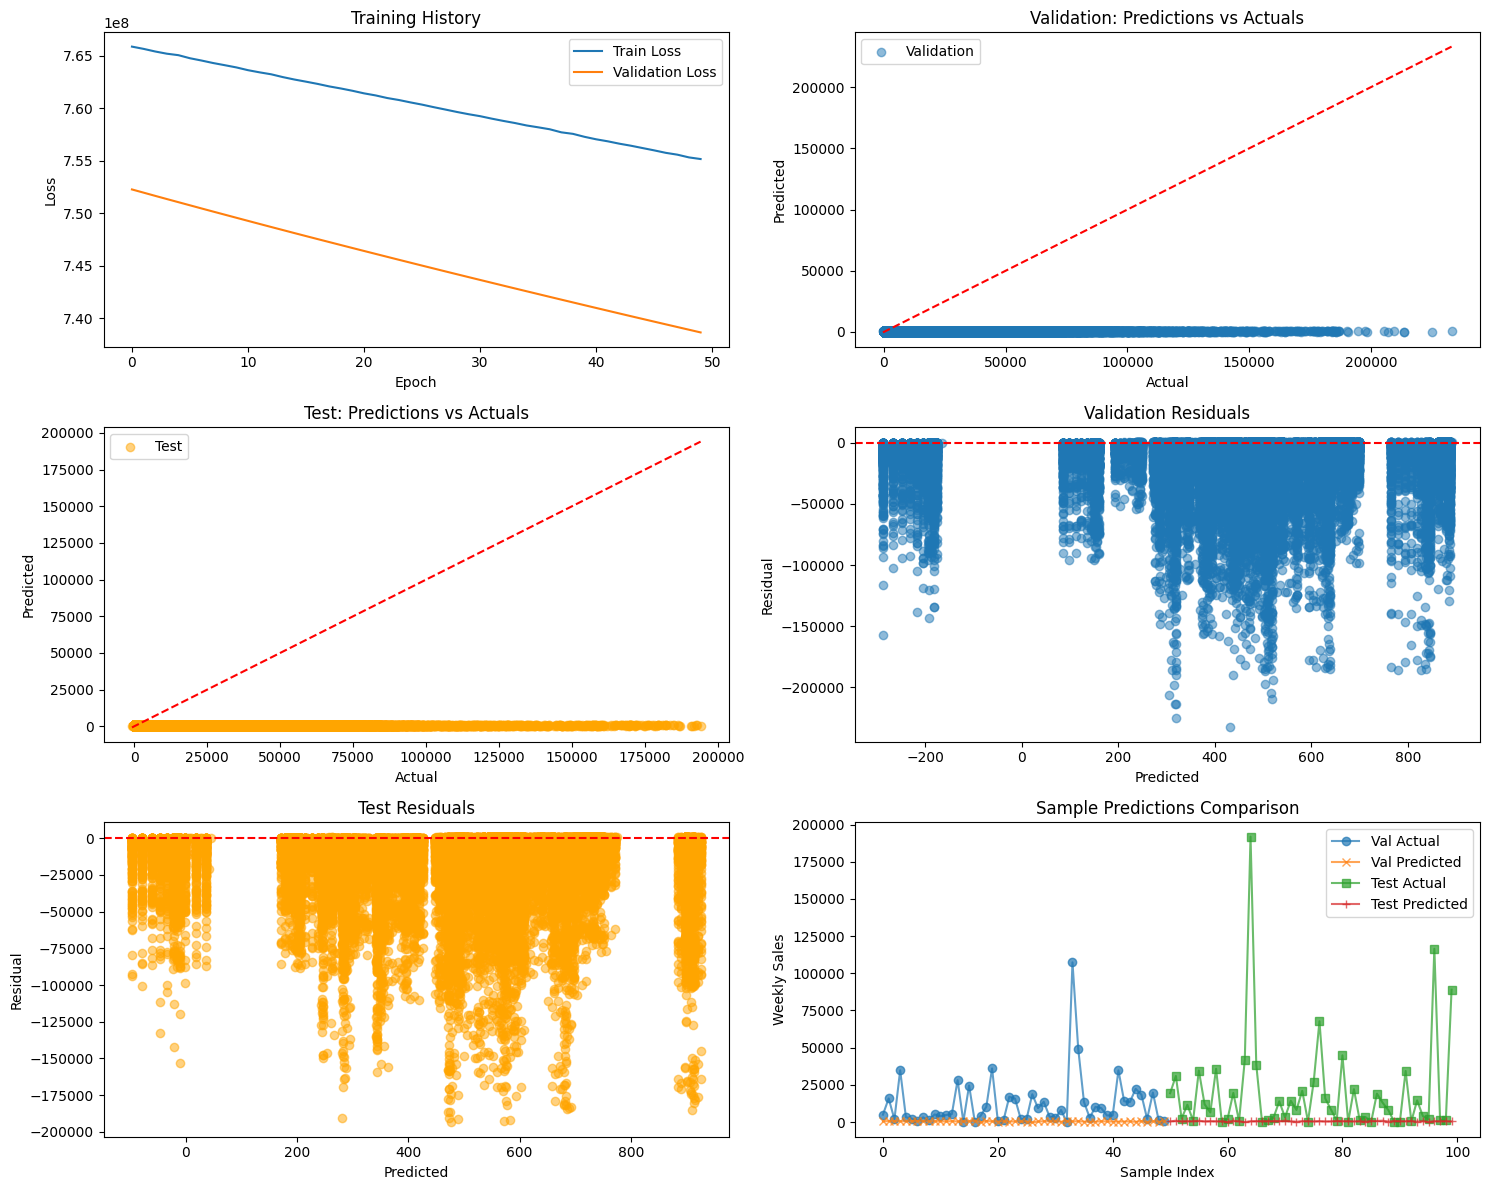

In [17]:
plt.figure(figsize=(15, 12))

# Plot training history
plt.subplot(3, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot validation predictions vs actuals
plt.subplot(3, 2, 2)
plt.scatter(val_actuals, val_predictions, alpha=0.5, label='Validation')
plt.plot([min(val_actuals), max(val_actuals)], [min(val_actuals), max(val_actuals)], 'r--')
plt.title('Validation: Predictions vs Actuals')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()

# Plot test predictions vs actuals
plt.subplot(3, 2, 3)
plt.scatter(test_actuals, test_predictions, alpha=0.5, label='Test', color='orange')
plt.plot([min(test_actuals), max(test_actuals)], [min(test_actuals), max(test_actuals)], 'r--')
plt.title('Test: Predictions vs Actuals')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()

# Plot validation residuals
plt.subplot(3, 2, 4)
val_residuals = np.array(val_predictions) - np.array(val_actuals)
plt.scatter(val_predictions, val_residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Validation Residuals')
plt.xlabel('Predicted')
plt.ylabel('Residual')

# Plot test residuals
plt.subplot(3, 2, 5)
test_residuals = np.array(test_predictions) - np.array(test_actuals)
plt.scatter(test_predictions, test_residuals, alpha=0.5, color='orange')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Test Residuals')
plt.xlabel('Predicted')
plt.ylabel('Residual')

# Plot sample predictions comparison
plt.subplot(3, 2, 6)
sample_indices = np.random.choice(len(val_actuals), 50, replace=False)
sample_val_actuals = [val_actuals[i] for i in sample_indices]
sample_val_predictions = [val_predictions[i] for i in sample_indices]

sample_test_indices = np.random.choice(len(test_actuals), 50, replace=False)
sample_test_actuals = [test_actuals[i] for i in sample_test_indices]
sample_test_predictions = [test_predictions[i] for i in sample_test_indices]

plt.plot(range(50), sample_val_actuals, label='Val Actual', marker='o', alpha=0.7)
plt.plot(range(50), sample_val_predictions, label='Val Predicted', marker='x', alpha=0.7)
plt.plot(range(50, 100), sample_test_actuals, label='Test Actual', marker='s', alpha=0.7)
plt.plot(range(50, 100), sample_test_predictions, label='Test Predicted', marker='+', alpha=0.7)
plt.title('Sample Predictions Comparison')
plt.xlabel('Sample Index')
plt.ylabel('Weekly Sales')
plt.legend()

plt.tight_layout()
plt.savefig('training_results.png', dpi=300, bbox_inches='tight')
plt.show()

# Log the plot to wandb
wandb.log({"training_results": wandb.Image('training_results.png')})


In [18]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
final_test_mae,▁
final_test_mse,▁
final_test_rmse,▁
final_val_mae,▁
final_val_mse,▁
final_val_rmse,▁
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,████▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁
val_loss,████▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁
val_mae,███▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
